# Import Python Libaries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams.update({'font.size':20})
import seaborn as sns
%matplotlib inline
import re
import string
import spacy 
import os
import sys
import numpy as np

nlp = spacy.load('en', disable=['ner', 'parser'])
import nltk
from nltk.stem.snowball import SnowballStemmer
from scipy import stats

from time import time
from collections import defaultdict
import gc
import io
import random

from __future__ import print_function, division
from builtins import range
import os
import sys
import numpy as np
import operator

import nltk
nltk.download('all')
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize


import keras
from keras.models import Model, Sequential
from keras.layers import *
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalAveragePooling1D, Dropout, Conv1D, GRU, Layer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD
from sklearn.metrics import roc_auc_score
import keras.backend as K
from keras.layers import CuDNNLSTM as LSTM
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras import metrics
from tensorflow.python.keras.metrics import Metric
from tensorflow.keras.utils import plot_model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.utils import shuffle, class_weight
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, roc_auc_score, f1_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# install tensorflow 2.0
#!pip uninstall tensorflow
#!pip install tensorflow-gpu==2.1.0

In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
# check the availability of GPU
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [0]:
# Mount Google Drive (to save the downloaded files)
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### GloVe Pretrained Word Embedding loading

In [0]:
# Load GloVe Embeddings
print('Loading GloVe Embeddings.')

glove_embeddings = {}
f = open('/gdrive/My Drive/glove.42B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs
f.close()

print('Found %s word vectors.' % len(glove_embeddings))


Loading GloVe Embeddings.
Found 1917495 word vectors.


# Import cleaned data

In [0]:
data = pd.read_csv('/gdrive/My Drive/cleaned_data.csv', encoding = "ISO-8859-1")

In [0]:
data.head(5)

,Unnamed: 0,_unit_id,positivity,relevance,date,texts
0,0,842613455,3.0,1,8/14/91,yield cd fall late week new york yield cert...
1,1,842613456,NaN,0,8/21/07,morning brief white house seek limit child i...
2,2,842613457,NaN,0,11/14/91,banking bill negotiator set compromise plan...
3,3,842613458,NaN,0,6/16/86,manager journal sniff drug abuser quick fix ...
4,4,842613459,3.0,1,10/4/02,currency trading dollar remain tight range a...


# Text Classification

In [0]:
data = data[['texts','relevance']]

## Oversampling
Oversampling the minority by looking for the synonyms of each word in minor class

In [0]:
# use WordNet to find synonyms of each word and oversample the minor class
from nltk.corpus import wordnet 

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

In [0]:
# minor class data set
df = data[data['relevance']==1]

In [0]:
# function to oversample data
def oversample(wordlist): 
  new_words = wordlist
  for i in range(len(wordlist)):
    for random_word in wordlist[wordlist.index[i]]:
      try:
        synonyms = get_synonyms(random_word)  # find synonyms list of each word
        synonym = random.choice(list(synonyms))  # random select one sysnonym to replace the original word
        new_words[new_words.index[i]] = [synonym if word == random_word else word for word in new_words[new_words.index[i]]]
      except:
        pass
    s = ' '.join(new_words[new_words.index[i]]) # join the list of synonyms to a new sentence
    new_words[new_words.index[i]] = s
  augmented_sentences = pd.DataFrame(columns=['texts','relevance'])
  augmented_sentences['texts'] = new_words
  augmented_sentences['relevance']  = df['relevance']
  return augmented_sentences

In [0]:
# oversample the minor class data twice
sentence = df['texts']
word_list = sentence.str.split()
data_cleaned = data[['texts','relevance']]

random.seed(45)
data_cleaned = data_cleaned.append(oversample(word_list))

random.seed(98)
data_cleaned = data_cleaned.append(oversample(word_list))

In [0]:
dist = data_cleaned.groupby('relevance').count()
dist

,texts
relevance,
0,6571
1,4260


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


<Figure size 432x288 with 0 Axes>

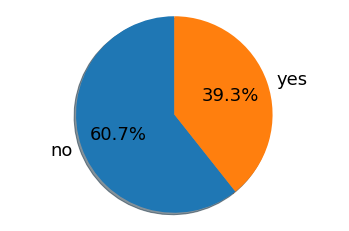

In [0]:
# pie chart of distribution of news relevance
figure(figsize=(6,4))
fig1, ax1 = plt.subplots()
sizes = dist.values
label = ['no', 'yes']
plt.rcParams.update({'font.size':18})
ax1.pie(sizes, labels=label, autopct='%1.1f%%',
        shadow=True, startangle=90)
#ax1.set_title('relevance to US economy')
ax1.axis('equal')    
plt.show()

In [0]:
# to ramdom shuffle data
data_cleaned = shuffle(data_cleaned)

In [0]:
# reset data index
data_cleaned = data_cleaned.reset_index()

In [0]:
data_cleaned.head(5)

,index,texts,relevance
0,3698,southward thyroxine type coke super uracil ato...,1
1,7107,market post modest gain merger involvement n...,0
2,261,angstrom uracil coulomb type uracil angstrom ...,1
3,3170,gold leap high nearly year new york ...,1
4,5014,revive interest push stock high sale week ...,0


## Bi-LSTM

In [0]:
# some configuration
MAX_SEQUENCE_LENGTH = 432   # max sentence length 432 words
EMBEDDING_DIM = 300    # word vector dimension


### Word Embedding Weights

In [0]:
# load in pre-trained word vectors
# shape: MAX_VOCAB_SIZE x word vector dimension
MAX_VOCAB_SIZE = 50000     # how many words will be used from dictionary 

print('Loading word vectors...')
word2vec = glove_embeddings

# load dataset
sentences = data_cleaned['texts'].fillna("DUMMY_VALUE").values

# convert the sentences (strings) into integers
# return a list of the index of every word in every sentence
num_words = MAX_VOCAB_SIZE
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(sentences)   # word counts on unique words, see below

# word2idx: number of unique words with index (Dictionary of word index)
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Loading word vectors...
Found 42878 unique tokens.


In [0]:
# prepare embedding matrix
# use the word and index in word2idx to look for the word vector (numeric)
# embedding_matrix
# size: # of unique words x D
n = 0
uncovered_words = {}
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE,len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        #print(embedding_vector)
        if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector
        else:
            n = n + 1
            uncovered_words[n] = word
print('{}, or {:.2%} of total {} unique words are not covered'.format(n, n/len(word2idx), len(word2idx)))

Filling pre-trained embeddings...
8494, or 19.81% of total 42878 unique words are not covered


### Padding

In [0]:
sequences = tokenizer.texts_to_sequences(data_cleaned['texts'].values)
texts = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test data tensor:', texts.shape)

Shape of test data tensor: (10831, 432)


### Model

##### Bi-LSTM

Building Bi-LSTM model...
Training model...
Train on 8772 samples, validate on 975 samples
Epoch 1/200
8772/8772 [==============================] - 37s 4ms/sample - loss: 0.5923 - tp: 890.0000 - fp: 0.0000e+00 - tn: 5353.0000 - fn: 2529.0000 - accuracy: 0.7117 - precision: 1.0000 - recall: 0.2603 - auc: 0.7679 - val_loss: 0.5509 - val_tp: 131.0000 - val_fp: 0.0000e+00 - val_tn: 560.0000 - val_fn: 284.0000 - val_accuracy: 0.7087 - val_precision: 1.0000 - val_recall: 0.3157 - val_auc: 0.8370
Epoch 2/200
8772/8772 [==============================] - 32s 4ms/sample - loss: 0.4766 - tp: 1519.0000 - fp: 0.0000e+00 - tn: 5353.0000 - fn: 1900.0000 - accuracy: 0.7834 - precision: 1.0000 - recall: 0.4443 - auc: 0.8407 - val_loss: 0.4387 - val_tp: 275.0000 - val_fp: 0.0000e+00 - val_tn: 560.0000 - val_fn: 140.0000 - val_accuracy: 0.8564 - val_precision: 1.0000 - val_recall: 0.6627 - val_auc: 0.8537
Epoch 3/200
8772/8772 [==============================] - 32s 4ms/sample - loss: 0.3700 - tp: 2305.00

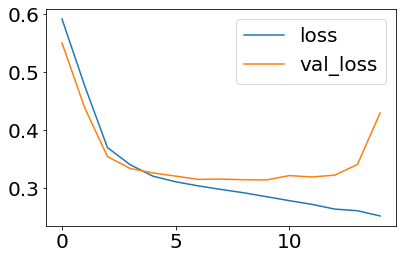

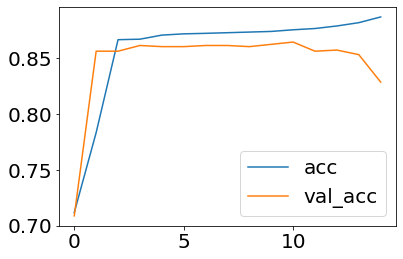

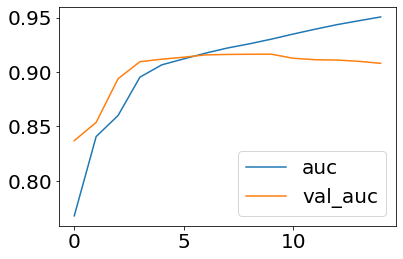

1084/1084 [==============================] - 1s 686us/sample - loss: 0.3298 - tp: 265.0000 - fp: 6.0000 - tn: 652.0000 - fn: 161.0000 - accuracy: 0.8459 - precision: 0.9779 - recall: 0.6221 - auc: 0.9098
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 37s 4ms/sample - loss: 0.6064 - tp: 881.0000 - fp: 0.0000e+00 - tn: 5352.0000 - fn: 2540.0000 - accuracy: 0.7105 - precision: 1.0000 - recall: 0.2575 - auc: 0.7542 - val_loss: 0.5687 - val_tp: 129.0000 - val_fp: 0.0000e+00 - val_tn: 562.0000 - val_fn: 284.0000 - val_accuracy: 0.7087 - val_precision: 1.0000 - val_recall: 0.3123 - val_auc: 0.8280
Epoch 2/200
8773/8773 [==============================] - 32s 4ms/sample - loss: 0.4928 - tp: 1491.0000 - fp: 0.0000e+00 - tn: 5352.0000 - fn: 1930.0000 - accuracy: 0.7800 - precision: 1.0000 - recall: 0.4358 - auc: 0.8375 - val_loss: 0.4658 - val_tp: 262.0000 - val_fp: 0.0000e+00 - val_tn: 562.0000 - val_fn: 151.0000 - val_ac

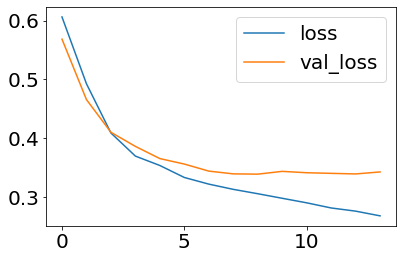

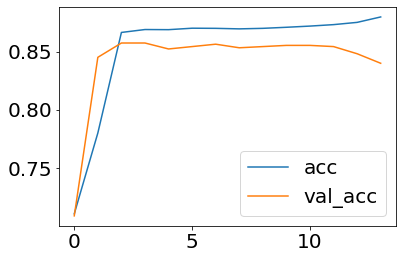

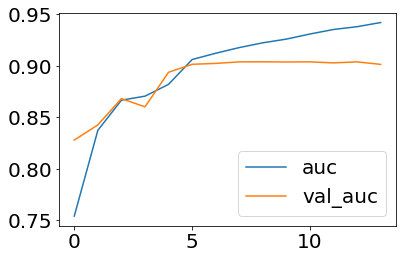

1083/1083 [==============================] - 1s 696us/sample - loss: 0.3248 - tp: 279.0000 - fp: 3.0000 - tn: 654.0000 - fn: 147.0000 - accuracy: 0.8615 - precision: 0.9894 - recall: 0.6549 - auc: 0.9165
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 36s 4ms/sample - loss: 0.6013 - tp: 1187.0000 - fp: 106.0000 - tn: 5239.0000 - fn: 2241.0000 - accuracy: 0.7325 - precision: 0.9180 - recall: 0.3463 - auc: 0.7548 - val_loss: 0.5225 - val_tp: 131.0000 - val_fp: 0.0000e+00 - val_tn: 569.0000 - val_fn: 275.0000 - val_accuracy: 0.7179 - val_precision: 1.0000 - val_recall: 0.3227 - val_auc: 0.8234
Epoch 2/200
8773/8773 [==============================] - 32s 4ms/sample - loss: 0.4451 - tp: 1941.0000 - fp: 6.0000 - tn: 5339.0000 - fn: 1487.0000 - accuracy: 0.8298 - precision: 0.9969 - recall: 0.5662 - auc: 0.8354 - val_loss: 0.3966 - val_tp: 266.0000 - val_fp: 2.0000 - val_tn: 567.0000 - val_fn: 140.0000 - val_accuracy: 0

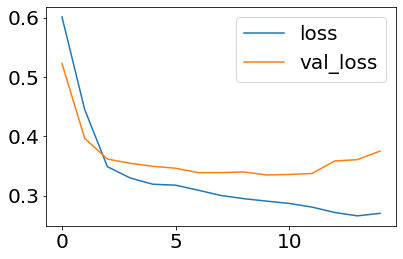

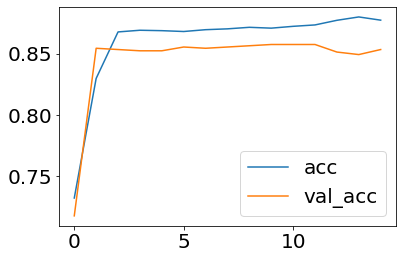

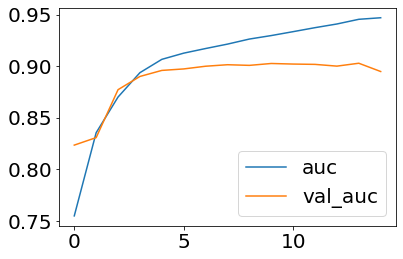

1083/1083 [==============================] - 1s 647us/sample - loss: 0.3199 - tp: 288.0000 - fp: 2.0000 - tn: 655.0000 - fn: 138.0000 - accuracy: 0.8707 - precision: 0.9931 - recall: 0.6761 - auc: 0.9057
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 38s 4ms/sample - loss: 0.6062 - tp: 1095.0000 - fp: 5.0000 - tn: 5342.0000 - fn: 2331.0000 - accuracy: 0.7337 - precision: 0.9955 - recall: 0.3196 - auc: 0.7878 - val_loss: 0.5442 - val_tp: 120.0000 - val_fp: 0.0000e+00 - val_tn: 567.0000 - val_fn: 288.0000 - val_accuracy: 0.7046 - val_precision: 1.0000 - val_recall: 0.2941 - val_auc: 0.8146
Epoch 2/200
8773/8773 [==============================] - 33s 4ms/sample - loss: 0.4637 - tp: 1802.0000 - fp: 3.0000 - tn: 5344.0000 - fn: 1624.0000 - accuracy: 0.8145 - precision: 0.9983 - recall: 0.5260 - auc: 0.8369 - val_loss: 0.4197 - val_tp: 262.0000 - val_fp: 1.0000 - val_tn: 566.0000 - val_fn: 146.0000 - val_accuracy: 0.8

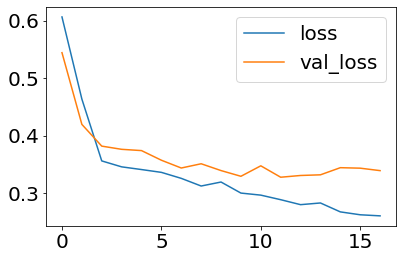

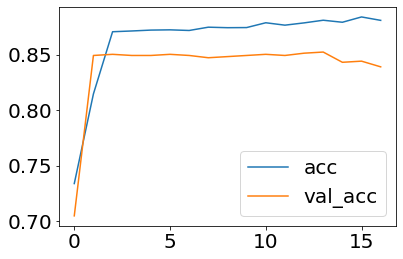

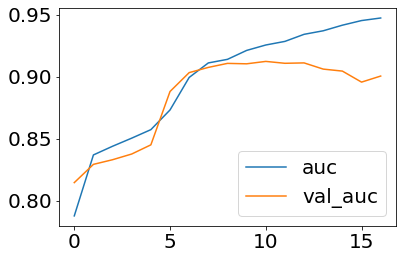

1083/1083 [==============================] - 1s 681us/sample - loss: 0.3209 - tp: 278.0000 - fp: 3.0000 - tn: 654.0000 - fn: 148.0000 - accuracy: 0.8606 - precision: 0.9893 - recall: 0.6526 - auc: 0.9078
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 39s 4ms/sample - loss: 0.6161 - tp: 1285.0000 - fp: 423.0000 - tn: 4928.0000 - fn: 2137.0000 - accuracy: 0.7082 - precision: 0.7523 - recall: 0.3755 - auc: 0.7243 - val_loss: 0.5439 - val_tp: 129.0000 - val_fp: 0.0000e+00 - val_tn: 563.0000 - val_fn: 283.0000 - val_accuracy: 0.7097 - val_precision: 1.0000 - val_recall: 0.3131 - val_auc: 0.8187
Epoch 2/200
8773/8773 [==============================] - 33s 4ms/sample - loss: 0.4601 - tp: 1611.0000 - fp: 4.0000 - tn: 5347.0000 - fn: 1811.0000 - accuracy: 0.7931 - precision: 0.9975 - recall: 0.4708 - auc: 0.8362 - val_loss: 0.3832 - val_tp: 272.0000 - val_fp: 2.0000 - val_tn: 561.0000 - val_fn: 140.0000 - val_accuracy: 0

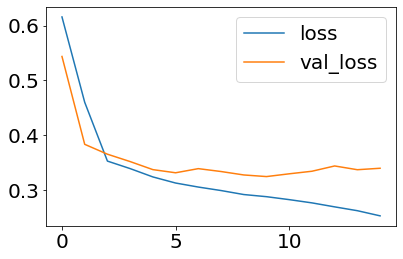

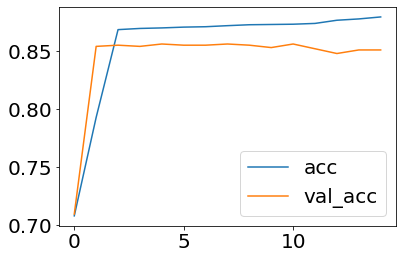

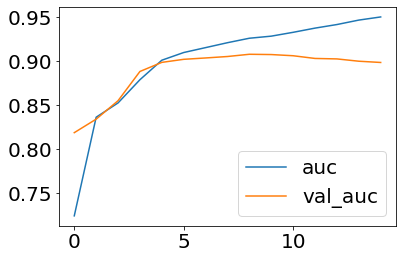

1083/1083 [==============================] - 1s 671us/sample - loss: 0.3445 - tp: 274.0000 - fp: 4.0000 - tn: 653.0000 - fn: 152.0000 - accuracy: 0.8560 - precision: 0.9856 - recall: 0.6432 - auc: 0.8875
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 37s 4ms/sample - loss: 0.5964 - tp: 1074.0000 - fp: 16.0000 - tn: 5334.0000 - fn: 2349.0000 - accuracy: 0.7304 - precision: 0.9853 - recall: 0.3138 - auc: 0.7559 - val_loss: 0.5292 - val_tp: 126.0000 - val_fp: 0.0000e+00 - val_tn: 564.0000 - val_fn: 285.0000 - val_accuracy: 0.7077 - val_precision: 1.0000 - val_recall: 0.3066 - val_auc: 0.8151
Epoch 2/200
8773/8773 [==============================] - 32s 4ms/sample - loss: 0.4163 - tp: 1915.0000 - fp: 12.0000 - tn: 5338.0000 - fn: 1508.0000 - accuracy: 0.8267 - precision: 0.9938 - recall: 0.5595 - auc: 0.8369 - val_loss: 0.3782 - val_tp: 268.0000 - val_fp: 1.0000 - val_tn: 563.0000 - val_fn: 143.0000 - val_accuracy: 0

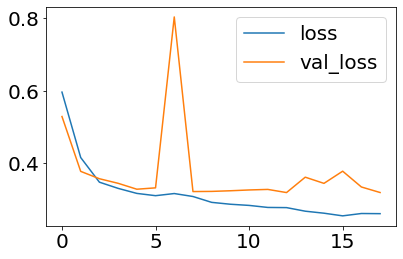

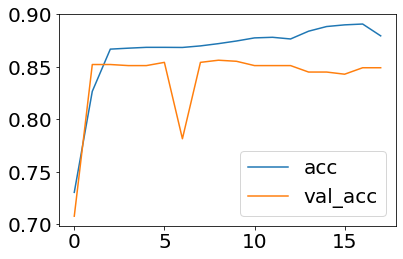

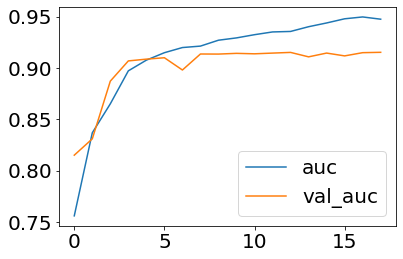

1083/1083 [==============================] - 1s 737us/sample - loss: 0.3076 - tp: 310.0000 - fp: 16.0000 - tn: 641.0000 - fn: 116.0000 - accuracy: 0.8781 - precision: 0.9509 - recall: 0.7277 - auc: 0.9136
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 37s 4ms/sample - loss: 0.5953 - tp: 1061.0000 - fp: 0.0000e+00 - tn: 5351.0000 - fn: 2361.0000 - accuracy: 0.7309 - precision: 1.0000 - recall: 0.3101 - auc: 0.7345 - val_loss: 0.5501 - val_tp: 127.0000 - val_fp: 0.0000e+00 - val_tn: 563.0000 - val_fn: 285.0000 - val_accuracy: 0.7077 - val_precision: 1.0000 - val_recall: 0.3083 - val_auc: 0.8082
Epoch 2/200
8773/8773 [==============================] - 33s 4ms/sample - loss: 0.4801 - tp: 1516.0000 - fp: 1.0000 - tn: 5350.0000 - fn: 1906.0000 - accuracy: 0.7826 - precision: 0.9993 - recall: 0.4430 - auc: 0.8350 - val_loss: 0.4543 - val_tp: 260.0000 - val_fp: 0.0000e+00 - val_tn: 563.0000 - val_fn: 152.0000 - val_accu

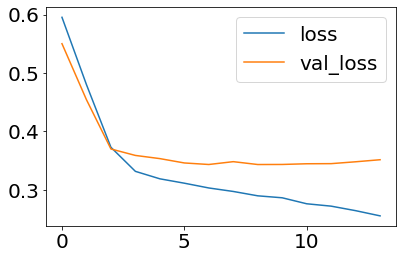

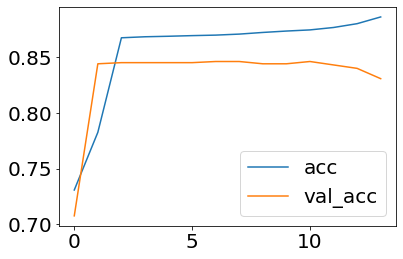

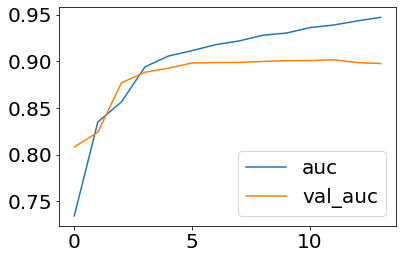

1083/1083 [==============================] - 1s 674us/sample - loss: 0.3039 - tp: 308.0000 - fp: 20.0000 - tn: 637.0000 - fn: 118.0000 - accuracy: 0.8726 - precision: 0.9390 - recall: 0.7230 - auc: 0.9116
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 39s 4ms/sample - loss: 0.6036 - tp: 1314.0000 - fp: 231.0000 - tn: 5122.0000 - fn: 2106.0000 - accuracy: 0.7336 - precision: 0.8505 - recall: 0.3842 - auc: 0.7758 - val_loss: 0.5291 - val_tp: 136.0000 - val_fp: 0.0000e+00 - val_tn: 561.0000 - val_fn: 278.0000 - val_accuracy: 0.7149 - val_precision: 1.0000 - val_recall: 0.3285 - val_auc: 0.8107
Epoch 2/200
8773/8773 [==============================] - 32s 4ms/sample - loss: 0.4506 - tp: 1974.0000 - fp: 8.0000 - tn: 5345.0000 - fn: 1446.0000 - accuracy: 0.8343 - precision: 0.9960 - recall: 0.5772 - auc: 0.8349 - val_loss: 0.4173 - val_tp: 267.0000 - val_fp: 1.0000 - val_tn: 560.0000 - val_fn: 147.0000 - val_accuracy: 

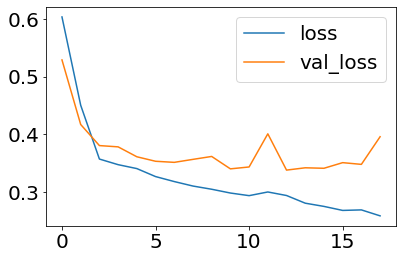

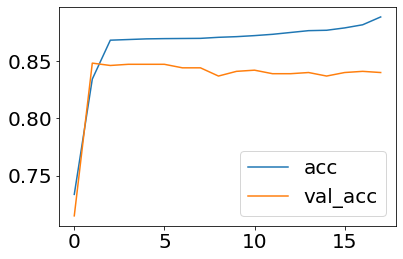

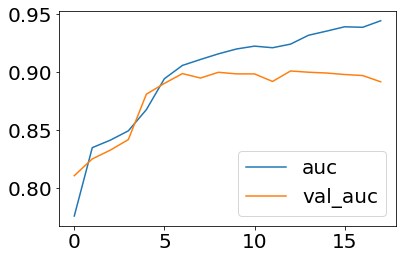

1083/1083 [==============================] - 1s 704us/sample - loss: 0.3301 - tp: 299.0000 - fp: 18.0000 - tn: 639.0000 - fn: 127.0000 - accuracy: 0.8661 - precision: 0.9432 - recall: 0.7019 - auc: 0.8910
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 37s 4ms/sample - loss: 0.5944 - tp: 1012.0000 - fp: 1.0000 - tn: 5337.0000 - fn: 2423.0000 - accuracy: 0.7237 - precision: 0.9990 - recall: 0.2946 - auc: 0.7605 - val_loss: 0.5376 - val_tp: 125.0000 - val_fp: 0.0000e+00 - val_tn: 576.0000 - val_fn: 274.0000 - val_accuracy: 0.7190 - val_precision: 1.0000 - val_recall: 0.3133 - val_auc: 0.8302
Epoch 2/200
8773/8773 [==============================] - 32s 4ms/sample - loss: 0.4677 - tp: 1662.0000 - fp: 1.0000 - tn: 5337.0000 - fn: 1773.0000 - accuracy: 0.7978 - precision: 0.9994 - recall: 0.4838 - auc: 0.8457 - val_loss: 0.4251 - val_tp: 260.0000 - val_fp: 2.0000 - val_tn: 574.0000 - val_fn: 139.0000 - val_accuracy: 0.

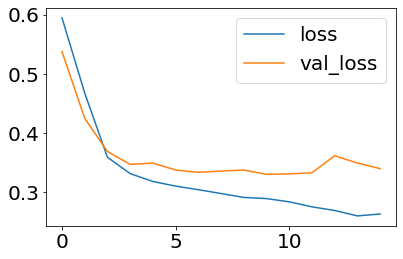

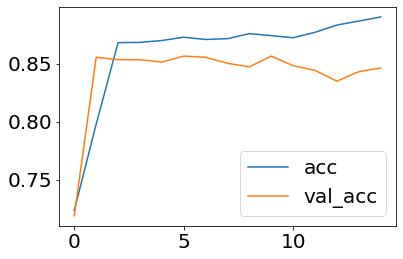

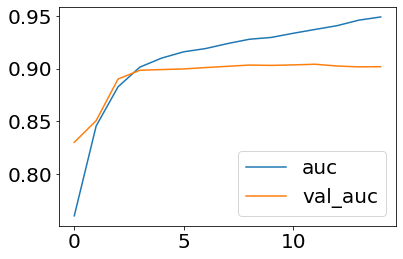

1083/1083 [==============================] - 1s 737us/sample - loss: 0.3047 - tp: 288.0000 - fp: 2.0000 - tn: 655.0000 - fn: 138.0000 - accuracy: 0.8707 - precision: 0.9931 - recall: 0.6761 - auc: 0.9147
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 37s 4ms/sample - loss: 0.5848 - tp: 949.0000 - fp: 0.0000e+00 - tn: 5353.0000 - fn: 2471.0000 - accuracy: 0.7183 - precision: 1.0000 - recall: 0.2775 - auc: 0.7647 - val_loss: 0.5361 - val_tp: 130.0000 - val_fp: 0.0000e+00 - val_tn: 561.0000 - val_fn: 284.0000 - val_accuracy: 0.7087 - val_precision: 1.0000 - val_recall: 0.3140 - val_auc: 0.8282
Epoch 2/200
8773/8773 [==============================] - 33s 4ms/sample - loss: 0.4540 - tp: 1845.0000 - fp: 11.0000 - tn: 5342.0000 - fn: 1575.0000 - accuracy: 0.8192 - precision: 0.9941 - recall: 0.5395 - auc: 0.8408 - val_loss: 0.4360 - val_tp: 269.0000 - val_fp: 0.0000e+00 - val_tn: 561.0000 - val_fn: 145.0000 - val_accur

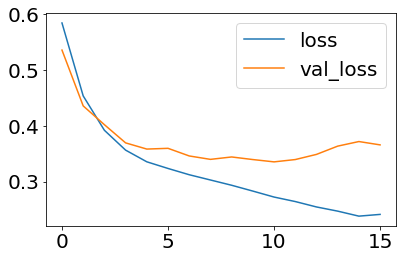

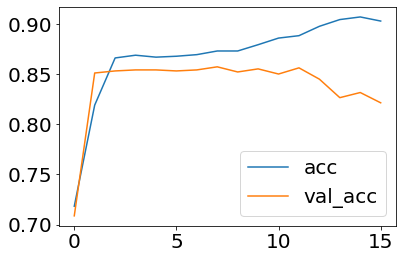

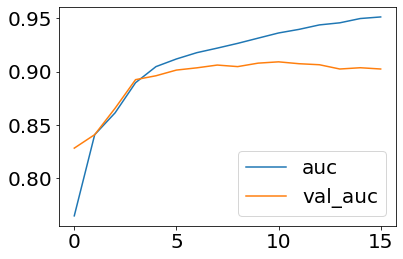

1083/1083 [==============================] - 1s 700us/sample - loss: 0.3068 - tp: 291.0000 - fp: 6.0000 - tn: 651.0000 - fn: 135.0000 - accuracy: 0.8698 - precision: 0.9798 - recall: 0.6831 - auc: 0.9199


In [0]:
# some configuration
VALIDATION_SPLIT = 0.1   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 200   # number of complete passes through the training dataset
LEARNING_RATE = 5E-5
N_SPLITS = 10


print('Building Bi-LSTM model...')
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state = 7)
cvscores_bilstm = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'f1', 'auc', 'cohen-kappa-score'])
labels = data_cleaned['relevance'].values
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]


for train, test in kfold.split(texts, labels):

  model = tf.keras.Sequential([
       tf.keras.layers.Embedding(num_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=True),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
       #tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, padding='valid', activation='relu', strides=1),
       #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
       tf.keras.layers.GlobalAveragePooling1D(),
       tf.keras.layers.Dense(16, activation='relu'),
       tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  
  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    metrics = METRICS,
  
  )



# Training model:

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
#  mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
# fit model
# load a saved model

#  from sklearn.utils import class_weight

  print('Training model...')
  r = model.fit(
    texts[train],
    labels[train],
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT,
    #callbacks=[history, lrate]
    #callbacks=[lr_schedule]
    callbacks=[es]
    #class_weight = class_weight_dict
    #use_multiprocessing=True
  )

#  saved_model = tf.keras.models.load_model('best_model.h5')
#  saved_model.summary()

  model.summary()

# plot some data
  plt.plot(r.history['loss'], label='loss')
  plt.plot(r.history['val_loss'], label='val_loss')
  plt.xlabel('epochs')
  plt.legend(frameon=False)
  plt.show()

# accuracies
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.xlabel('epochs')
  plt.legend(frameon=False)
  plt.show()

# auc
  plt.plot(r.history['auc'], label='auc')
  plt.plot(r.history['val_auc'], label='val_auc')
  plt.xlabel('epochs')
  plt.legend(frameon=False)
  plt.show()



  #scores = saved_model.evaluate(x = texts[test], y = labels[test])
  scores = model.evaluate(x = texts[test], y = labels[test])
  y_pred = model.predict(x=texts[test])
  y_pred = K.round(y_pred)
  ck = cohen_kappa_score(labels[test], y_pred)
  cvscores_bilstm = cvscores_bilstm.append({'tp': scores[1], 'fp': scores[2], 'tn': scores[3], 'fn': scores[4], 
                              'accuracy': scores[5],'precision': scores[6], 'recall': scores[7], 
                              'f1': 2 * (scores[6] * scores[7]) / (scores[6] + scores[7]),'auc': scores[8],
                              'cohen-kappa-score': ck}, ignore_index=True)

In [0]:
cvscores_bilstm

,tp,fp,tn,fn,accuracy,precision,recall,f1,auc,cohen-kappa-score
0,265.0,6.0,652.0,161.0,0.845941,0.977860,0.622066,0.760402,0.909831,0.654959
1,279.0,3.0,654.0,147.0,0.861496,0.989362,0.654930,0.788136,0.916506,0.691453
2,288.0,2.0,655.0,138.0,0.870729,0.993103,0.676056,0.804469,0.905657,0.713030
3,278.0,3.0,654.0,148.0,0.860572,0.989324,0.652582,0.786422,0.907797,0.689260
4,274.0,4.0,653.0,152.0,0.855956,0.985611,0.643192,0.778409,0.887517,0.678547
5,310.0,16.0,641.0,116.0,0.878116,0.950920,0.727700,0.824468,0.913572,0.733621
6,308.0,20.0,637.0,118.0,0.872576,0.939024,0.723005,0.816976,0.911604,0.721752
7,299.0,18.0,639.0,127.0,0.866113,0.943218,0.701878,0.804845,0.891022,0.706249
8,288.0,2.0,655.0,138.0,0.870729,0.993103,0.676056,0.804469,0.914730,0.713030
9,291.0,6.0,651.0,135.0,0.869806,0.979798,0.683099,0.804979,0.919855,0.711862


In [0]:
cvscores_bilstm.mean(axis = 0)

tp                   288.000000
fp                     8.000000
tn                   649.100000
fn                   138.000000
accuracy               0.865204
precision              0.974132
recall                 0.676056
f1                     0.797358
auc                    0.907809
cohen-kappa-score      0.701376
dtype: float64

In [0]:
cvscores_bilstm.to_csv("/gdrive/My Drive/bilstm.csv")

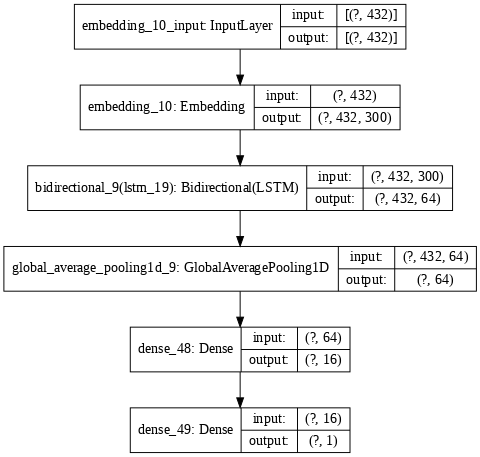

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot_bilstm.png', show_shapes=True, show_layer_names=True, dpi = 70)

##### Bi-LSTM + tf-idf (concatenate)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
# calculate Tfidf vector
word_vectorizer = TfidfVectorizer(
    max_features=500)

word_vectorizer.fit(data_cleaned['texts'])
tf_idf = word_vectorizer.transform(data_cleaned['texts'])
tf_idf = tf_idf.toarray()

In [0]:
texts_tf= np.concatenate([texts, tf_idf], axis = 1)  # concatenate word embedding and Tfidf vectors

Building Bi-LSTM model...
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 432, 300)     12863700    input_5[0][0]                    
__________________________________________________________________________________________________
layer_normalization_2 (LayerNor (None, 500)          1000        input_6[0][0]                    
__________________________________________________________________

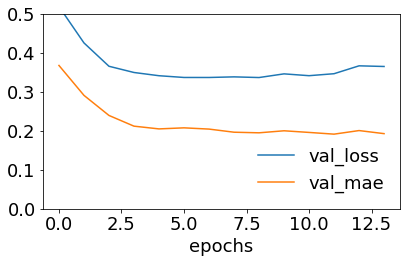

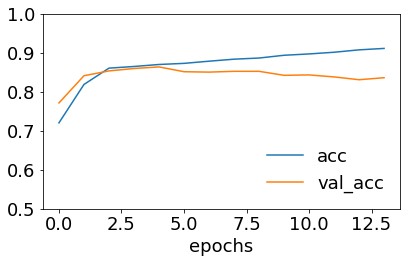

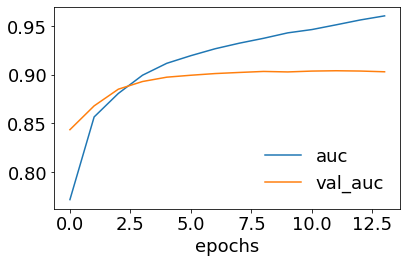

1084/1084 [==============================] - 1s 683us/sample - loss: 0.3152 - tp: 311.0000 - fp: 31.0000 - tn: 627.0000 - fn: 115.0000 - accuracy: 0.8653 - precision: 0.9094 - recall: 0.7300 - auc: 0.9160 - mae: 0.1880
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 432, 300)     12863700    input_7[0][0]                    
_______________________________________________________________________

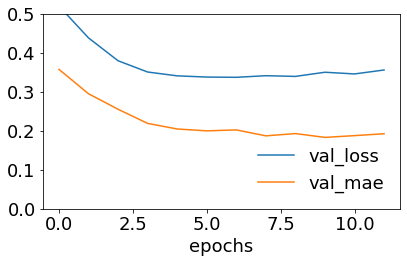

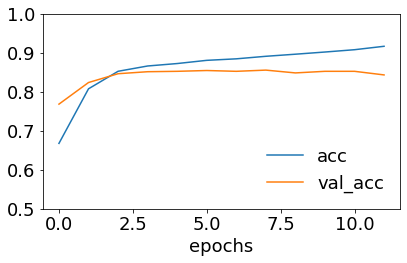

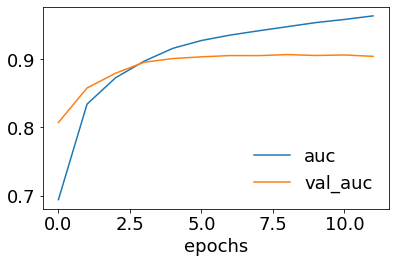

1083/1083 [==============================] - 1s 715us/sample - loss: 0.3179 - tp: 323.0000 - fp: 50.0000 - tn: 607.0000 - fn: 103.0000 - accuracy: 0.8587 - precision: 0.8660 - recall: 0.7582 - auc: 0.9129 - mae: 0.1973
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 432, 300)     12863700    input_9[0][0]                    
_______________________________________________________________________

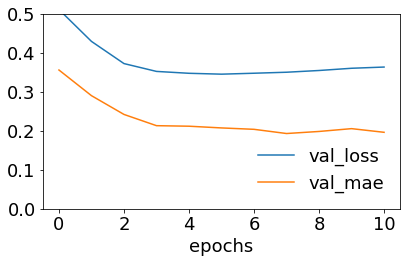

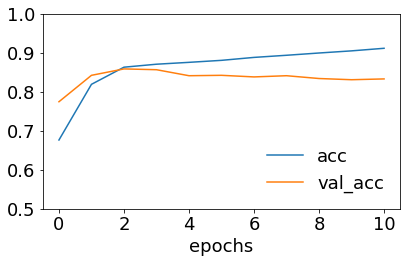

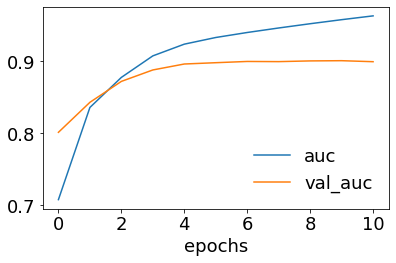

1083/1083 [==============================] - 1s 688us/sample - loss: 0.3141 - tp: 317.0000 - fp: 35.0000 - tn: 622.0000 - fn: 109.0000 - accuracy: 0.8670 - precision: 0.9006 - recall: 0.7441 - auc: 0.9143 - mae: 0.1958
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 432, 300)     12863700    input_11[0][0]                   
_______________________________________________________________________

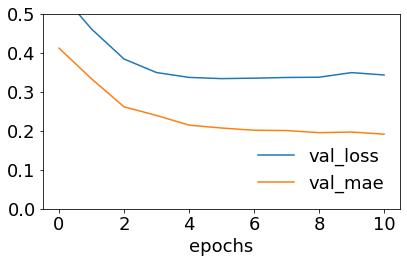

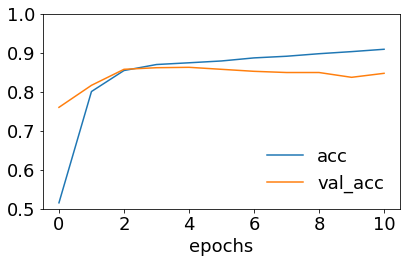

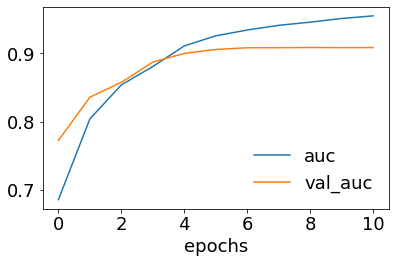

1083/1083 [==============================] - 1s 684us/sample - loss: 0.3098 - tp: 303.0000 - fp: 19.0000 - tn: 638.0000 - fn: 123.0000 - accuracy: 0.8689 - precision: 0.9410 - recall: 0.7113 - auc: 0.9218 - mae: 0.2003
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 432, 300)     12863700    input_13[0][0]                   
_______________________________________________________________________

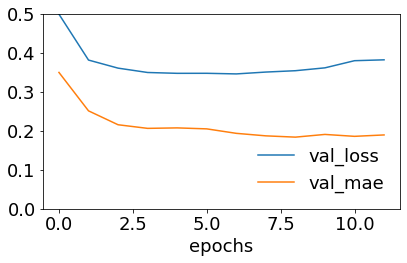

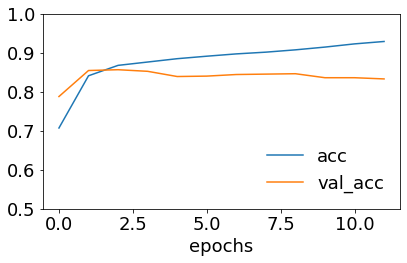

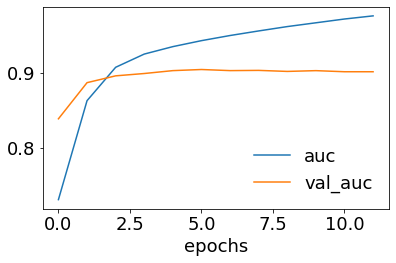

1083/1083 [==============================] - 1s 685us/sample - loss: 0.2938 - tp: 327.0000 - fp: 36.0000 - tn: 621.0000 - fn: 99.0000 - accuracy: 0.8753 - precision: 0.9008 - recall: 0.7676 - auc: 0.9253 - mae: 0.1752
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 432, 300)     12863700    input_15[0][0]                   
________________________________________________________________________

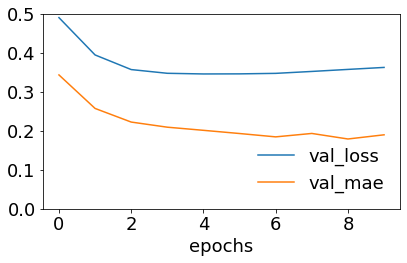

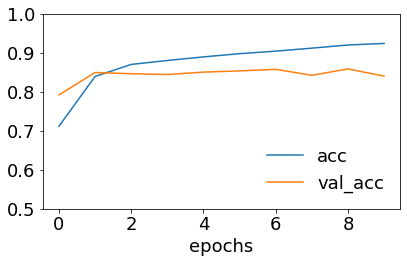

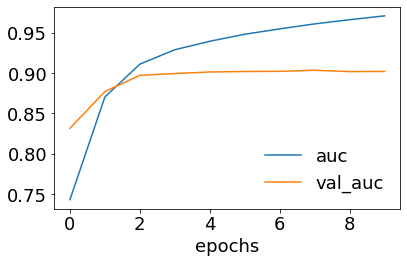

1083/1083 [==============================] - 1s 729us/sample - loss: 0.2710 - tp: 341.0000 - fp: 36.0000 - tn: 621.0000 - fn: 85.0000 - accuracy: 0.8883 - precision: 0.9045 - recall: 0.8005 - auc: 0.9421 - mae: 0.1724
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 432, 300)     12863700    input_17[0][0]                   
________________________________________________________________________

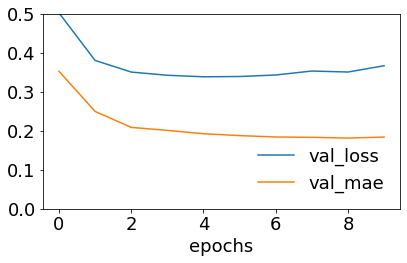

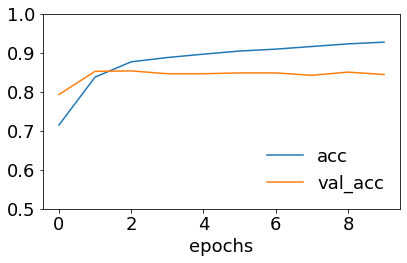

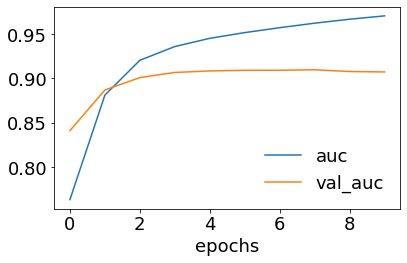

1083/1083 [==============================] - 1s 705us/sample - loss: 0.3133 - tp: 318.0000 - fp: 34.0000 - tn: 623.0000 - fn: 108.0000 - accuracy: 0.8689 - precision: 0.9034 - recall: 0.7465 - auc: 0.9162 - mae: 0.1820
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 432, 300)     12863700    input_19[0][0]                   
_______________________________________________________________________

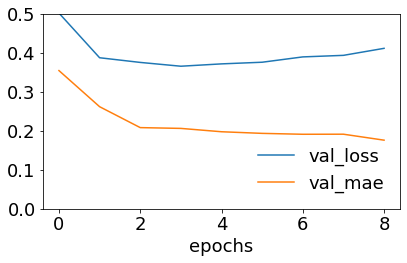

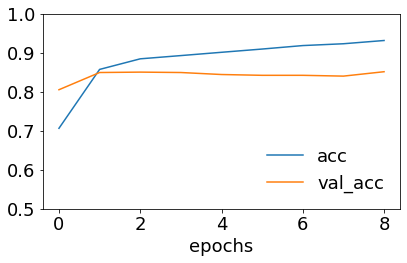

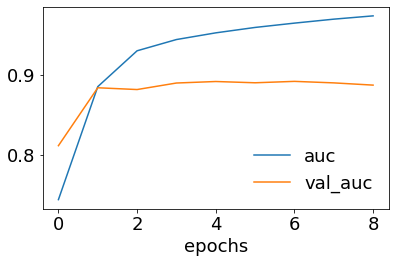

1083/1083 [==============================] - 1s 694us/sample - loss: 0.2888 - tp: 331.0000 - fp: 34.0000 - tn: 623.0000 - fn: 95.0000 - accuracy: 0.8809 - precision: 0.9068 - recall: 0.7770 - auc: 0.9311 - mae: 0.1807
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 432, 300)     12863700    input_21[0][0]                   
_______________________________________________________________________

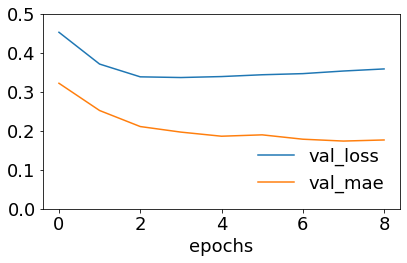

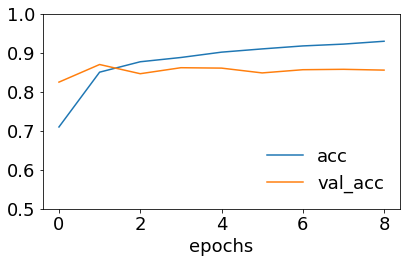

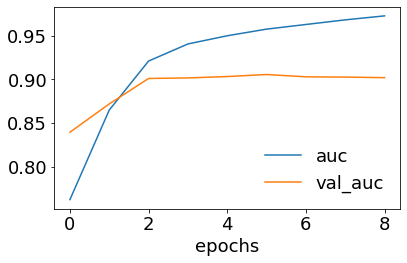

1083/1083 [==============================] - 1s 682us/sample - loss: 0.2824 - tp: 329.0000 - fp: 25.0000 - tn: 632.0000 - fn: 97.0000 - accuracy: 0.8873 - precision: 0.9294 - recall: 0.7723 - auc: 0.9328 - mae: 0.1791
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 432, 300)     12863700    input_23[0][0]                   
_______________________________________________________________________

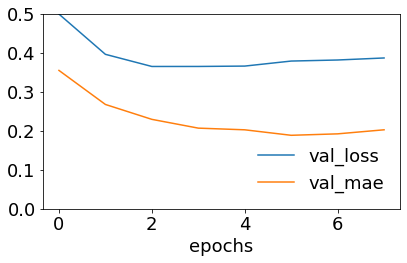

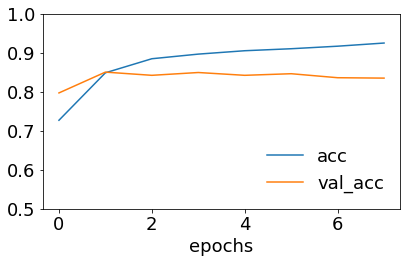

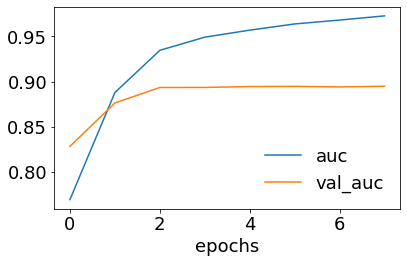

1083/1083 [==============================] - 1s 739us/sample - loss: 0.2997 - tp: 338.0000 - fp: 33.0000 - tn: 624.0000 - fn: 88.0000 - accuracy: 0.8883 - precision: 0.9111 - recall: 0.7934 - auc: 0.9338 - mae: 0.2059


In [0]:
# some configuration
VALIDATION_SPLIT = 0.1   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 200   # number of complete passes through the training dataset
LEARNING_RATE = 5E-5
N_SPLITS = 10


print('Building Bi-LSTM model...')
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state = 9)
cvscores_bilstm_tf = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'f1', 'auc', 'cohen-kappa-score'])
labels = data_cleaned['relevance'].values
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      'mae'
]



embedding_layer = tf.keras.layers.Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=True
)


for train, test in kfold.split(texts_tf, labels):

  x_train = texts_tf[train]
  x_test = texts_tf[test]
  x_train_1 = x_train[:, : MAX_SEQUENCE_LENGTH] # training set for word embeddings using GloVe
  x_train_2 = x_train[:, MAX_SEQUENCE_LENGTH:] # training set for tfidf feature
  x_test_1 = x_test[:, :MAX_SEQUENCE_LENGTH] # testing set for word embedding using GloVe
  x_test_2 = x_test[:, MAX_SEQUENCE_LENGTH:] # testing set for tfidf feature
  y_train = labels[train]
  y_test = labels[test]

  input_1 = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,)) # input layer using word embeddings
  x = embedding_layer(input_1)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)   # LSTM layer on embedding layer
 
  input_2 = tf.keras.Input(shape=(500,))  #input layer using tfidf
  tf_vec = tf.keras.layers.LayerNormalization()(input_2)  # tfidf layer
  tf_vec = tf.keras.layers.Dense(32, activation = 'relu')(tf_vec) # reduce the dimension of tfidf layer to 32
  
  concat_layer = tf.keras.layers.Concatenate()([x, tf_vec])  # concatenate LSTM and tfidf layer

  output_vector = tf.keras.layers.Dense(16, activation='relu')(concat_layer)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(output_vector)
  model = tf.keras.models.Model([input_1, input_2], output)
  model.summary()
  
  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    metrics = METRICS,
  
  )



# Training model:

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)  # early stopping to avoid overfitting
#  mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
# fit model
# load a saved model

#  from sklearn.utils import class_weight

  print('Training model...')
  r = model.fit(
    [x_train_1, x_train_2],
    y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT,
    #verbose = 0,
    #callbacks=[history, lrate]
    #callbacks=[lr_schedule]
    callbacks=[es]
    #class_weight = class_weight_dict
    #use_multiprocessing=True
  )

#  saved_model = tf.keras.models.load_model('best_model.h5')
#  model = saved_model
  model.summary()

  model.summary()

  figure(figsize=(6, 4))
  plt.rcParams.update({'figure.autolayout': True, 'font.size':18})
# plot some data
  plt.plot(r.history['val_loss'], label='val_loss')
  plt.plot(r.history['val_mae'], label='val_mae')
  plt.xlabel('epochs')
  plt.ylim(0, 0.5)
  plt.legend(frameon=False, loc = 'lower right')  
  plt.show()

# accuracies
  figure(figsize=(6, 4))
  plt.rcParams.update({'figure.autolayout': True, 'font.size':18})
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.xlabel('epochs')
  plt.ylim(0.5, 1)
  plt.legend(frameon=False, loc = 'lower right')
  plt.show()

# auc
  plt.plot(r.history['auc'], label='auc')
  plt.plot(r.history['val_auc'], label='val_auc')
  plt.xlabel('epochs')
  plt.legend(frameon=False)
  plt.show()

  scores = model.evaluate(x = [x_test_1, x_test_2], y = y_test)
  y_pred = model.predict(x=[x_test_1, x_test_2])
  y_pred = K.round(y_pred)
  ck = cohen_kappa_score(labels[test], y_pred)
  cvscores_bilstm_tf = cvscores_bilstm_tf.append({'tp': scores[1], 'fp': scores[2], 'tn': scores[3], 'fn': scores[4], 
                              'accuracy': scores[5],'precision': scores[6], 'recall': scores[7], 
                              'f1': 2 * (scores[6] * scores[7]) / (scores[6] + scores[7]),'auc': scores[8],
                              'cohen-kappa-score': ck}, ignore_index=True)

In [0]:
cvscores_bilstm_tf

,tp,fp,tn,fn,accuracy,precision,recall,f1,auc,cohen-kappa-score
0,311.0,31.0,627.0,115.0,0.865314,0.909357,0.730047,0.809896,0.915960,0.707529
1,323.0,50.0,607.0,103.0,0.858726,0.865952,0.758216,0.808511,0.912870,0.697365
2,317.0,35.0,622.0,109.0,0.867036,0.900568,0.744131,0.814910,0.914334,0.712621
3,303.0,19.0,638.0,123.0,0.868883,0.940994,0.711268,0.810160,0.921797,0.712947
4,327.0,36.0,621.0,99.0,0.875346,0.900826,0.767606,0.828897,0.925281,0.731838
5,341.0,36.0,621.0,85.0,0.888273,0.904509,0.800469,0.849315,0.942136,0.761064
6,318.0,34.0,623.0,108.0,0.868883,0.903409,0.746479,0.817481,0.916163,0.716612
7,331.0,34.0,623.0,95.0,0.880886,0.906849,0.776995,0.836915,0.931062,0.743973
8,329.0,25.0,632.0,97.0,0.887350,0.929379,0.772300,0.843590,0.932813,0.756733
9,338.0,33.0,624.0,88.0,0.888273,0.911051,0.793427,0.848181,0.933786,0.760459


In [0]:
cvscores_bilstm_tf.mean()

tp                   323.800000
fp                    33.300000
tn                   623.800000
fn                   102.200000
accuracy               0.874897
precision              0.907289
recall                 0.760094
f1                     0.826786
auc                    0.924620
cohen-kappa-score      0.730114
dtype: float64

In [0]:
cvscores_bilstm_tf.to_csv("/gdrive/My Drive/bilstm_tf.csv")

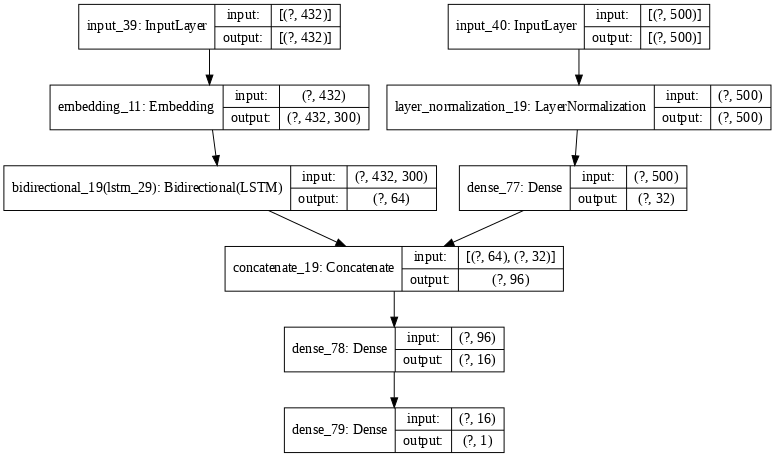

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot_bilstm_tf.png', show_shapes=True, show_layer_names=True, dpi = 70)

##### 1D CNN + Bi-LSTM + tf-idf

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
# calculate Tfidf vector
word_vectorizer = TfidfVectorizer(
    max_features=500)

word_vectorizer.fit(data_cleaned['texts'])
tf_idf = word_vectorizer.transform(data_cleaned['texts'])
tf_idf = tf_idf.toarray()
texts_tf= np.concatenate([texts, tf_idf], axis = 1)  # concatenate word embedding and Tfidf vectors

Building Bi-LSTM model...
Training model...
Train on 8772 samples, validate on 975 samples
Epoch 1/200
8772/8772 [==============================] - 39s 4ms/sample - loss: 0.5654 - tp: 2443.0000 - fp: 1541.0000 - tn: 3759.0000 - fn: 1029.0000 - accuracy: 0.7070 - precision: 0.6132 - recall: 0.7036 - auc: 0.7702 - mae: 0.4040 - val_loss: 0.3870 - val_tp: 248.0000 - val_fp: 0.0000e+00 - val_tn: 613.0000 - val_fn: 114.0000 - val_accuracy: 0.8831 - val_precision: 1.0000 - val_recall: 0.6851 - val_auc: 0.8485 - val_mae: 0.2782
Epoch 2/200
8772/8772 [==============================] - 28s 3ms/sample - loss: 0.3703 - tp: 2309.0000 - fp: 4.0000 - tn: 5296.0000 - fn: 1163.0000 - accuracy: 0.8670 - precision: 0.9983 - recall: 0.6650 - auc: 0.8511 - mae: 0.2491 - val_loss: 0.3259 - val_tp: 249.0000 - val_fp: 0.0000e+00 - val_tn: 613.0000 - val_fn: 113.0000 - val_accuracy: 0.8841 - val_precision: 1.0000 - val_recall: 0.6878 - val_auc: 0.8897 - val_mae: 0.2214
Epoch 3/200
8772/8772 [=================

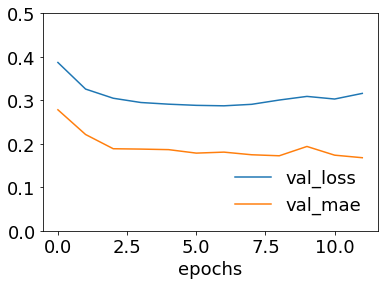

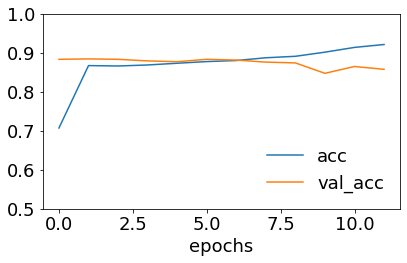

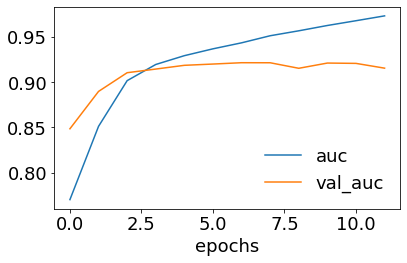

1084/1084 [==============================] - 1s 661us/sample - loss: 0.3049 - tp: 307.0000 - fp: 28.0000 - tn: 630.0000 - fn: 119.0000 - accuracy: 0.8644 - precision: 0.9164 - recall: 0.7207 - auc: 0.9144 - mae: 0.1905
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 33s 4ms/sample - loss: 0.4772 - tp: 1830.0000 - fp: 105.0000 - tn: 5195.0000 - fn: 1643.0000 - accuracy: 0.8008 - precision: 0.9457 - recall: 0.5269 - auc: 0.8312 - mae: 0.3289 - val_loss: 0.3362 - val_tp: 251.0000 - val_fp: 1.0000 - val_tn: 613.0000 - val_fn: 110.0000 - val_accuracy: 0.8862 - val_precision: 0.9960 - val_recall: 0.6953 - val_auc: 0.8894 - val_mae: 0.2188
Epoch 2/200
8773/8773 [==============================] - 28s 3ms/sample - loss: 0.3309 - tp: 2375.0000 - fp: 85.0000 - tn: 5215.0000 - fn: 1098.0000 - accuracy: 0.8652 - precision: 0.9654 - recall: 0.6838 - auc: 0.9052 - mae: 0.2178 - val_loss: 0.3009 - val_tp: 259.0000 - val_fp: 26.0

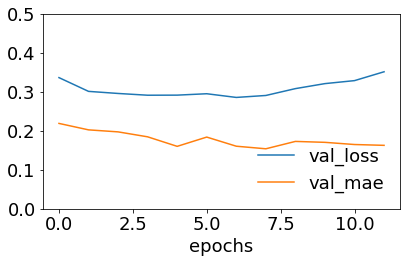

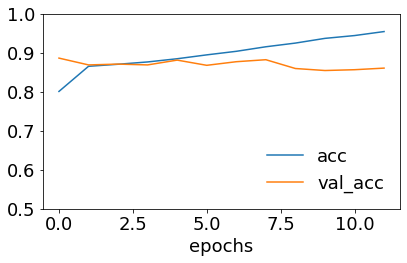

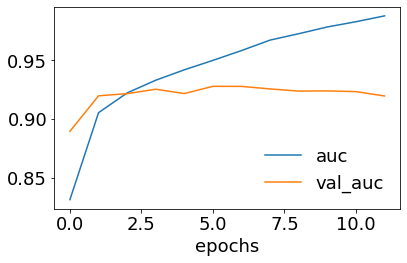

1083/1083 [==============================] - 1s 673us/sample - loss: 0.3114 - tp: 304.0000 - fp: 26.0000 - tn: 631.0000 - fn: 122.0000 - accuracy: 0.8633 - precision: 0.9212 - recall: 0.7136 - auc: 0.9243 - mae: 0.1699
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 33s 4ms/sample - loss: 0.5244 - tp: 1890.0000 - fp: 381.0000 - tn: 4920.0000 - fn: 1582.0000 - accuracy: 0.7762 - precision: 0.8322 - recall: 0.5444 - auc: 0.7944 - mae: 0.3753 - val_loss: 0.3762 - val_tp: 249.0000 - val_fp: 9.0000 - val_tn: 604.0000 - val_fn: 113.0000 - val_accuracy: 0.8749 - val_precision: 0.9651 - val_recall: 0.6878 - val_auc: 0.8816 - val_mae: 0.2695
Epoch 2/200
8773/8773 [==============================] - 29s 3ms/sample - loss: 0.3512 - tp: 2342.0000 - fp: 52.0000 - tn: 5249.0000 - fn: 1130.0000 - accuracy: 0.8653 - precision: 0.9783 - recall: 0.6745 - auc: 0.8991 - mae: 0.2404 - val_loss: 0.3208 - val_tp: 260.0000 - val_fp: 23.0

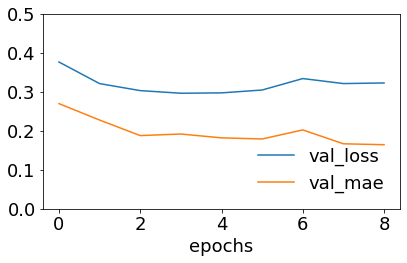

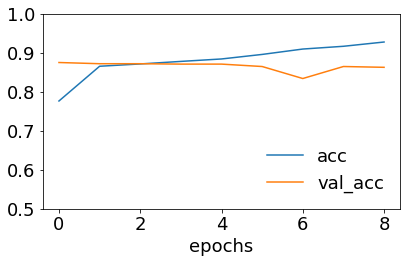

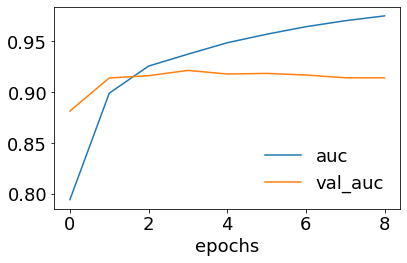

1083/1083 [==============================] - 1s 689us/sample - loss: 0.2725 - tp: 317.0000 - fp: 25.0000 - tn: 632.0000 - fn: 109.0000 - accuracy: 0.8763 - precision: 0.9269 - recall: 0.7441 - auc: 0.9415 - mae: 0.1779
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 33s 4ms/sample - loss: 0.5143 - tp: 2285.0000 - fp: 949.0000 - tn: 4351.0000 - fn: 1188.0000 - accuracy: 0.7564 - precision: 0.7066 - recall: 0.6579 - auc: 0.8004 - mae: 0.3520 - val_loss: 0.3705 - val_tp: 242.0000 - val_fp: 9.0000 - val_tn: 605.0000 - val_fn: 119.0000 - val_accuracy: 0.8687 - val_precision: 0.9641 - val_recall: 0.6704 - val_auc: 0.8677 - val_mae: 0.2520
Epoch 2/200
8773/8773 [==============================] - 28s 3ms/sample - loss: 0.3345 - tp: 2418.0000 - fp: 149.0000 - tn: 5151.0000 - fn: 1055.0000 - accuracy: 0.8628 - precision: 0.9420 - recall: 0.6962 - auc: 0.9081 - mae: 0.2245 - val_loss: 0.3117 - val_tp: 255.0000 - val_fp: 18.

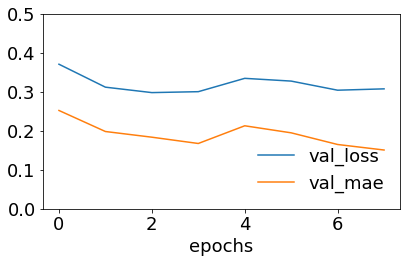

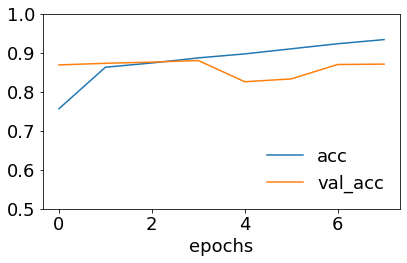

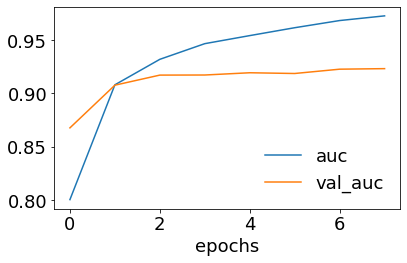

1083/1083 [==============================] - 1s 671us/sample - loss: 0.2951 - tp: 315.0000 - fp: 26.0000 - tn: 631.0000 - fn: 111.0000 - accuracy: 0.8735 - precision: 0.9238 - recall: 0.7394 - auc: 0.9218 - mae: 0.1884
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 33s 4ms/sample - loss: 0.4723 - tp: 1933.0000 - fp: 131.0000 - tn: 5161.0000 - fn: 1548.0000 - accuracy: 0.8086 - precision: 0.9365 - recall: 0.5553 - auc: 0.8433 - mae: 0.3339 - val_loss: 0.3414 - val_tp: 243.0000 - val_fp: 1.0000 - val_tn: 621.0000 - val_fn: 110.0000 - val_accuracy: 0.8862 - val_precision: 0.9959 - val_recall: 0.6884 - val_auc: 0.8788 - val_mae: 0.2179
Epoch 2/200
8773/8773 [==============================] - 29s 3ms/sample - loss: 0.3206 - tp: 2549.0000 - fp: 211.0000 - tn: 5081.0000 - fn: 932.0000 - accuracy: 0.8697 - precision: 0.9236 - recall: 0.7323 - auc: 0.9195 - mae: 0.2139 - val_loss: 0.3013 - val_tp: 261.0000 - val_fp: 20.0

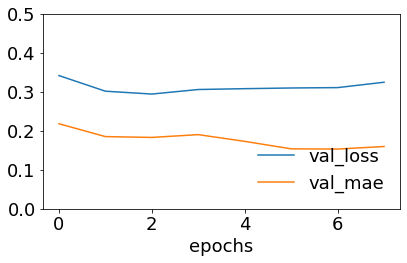

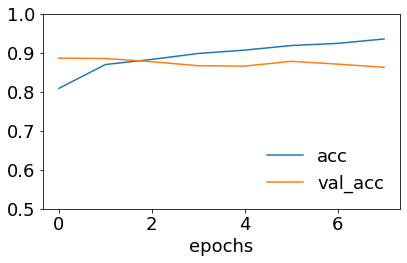

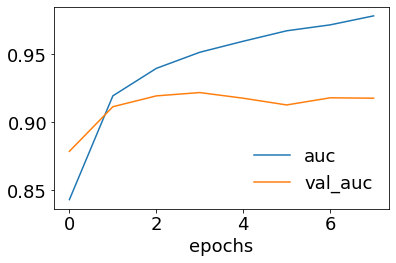

1083/1083 [==============================] - 1s 657us/sample - loss: 0.2830 - tp: 327.0000 - fp: 37.0000 - tn: 620.0000 - fn: 99.0000 - accuracy: 0.8744 - precision: 0.8984 - recall: 0.7676 - auc: 0.9429 - mae: 0.1863
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 32s 4ms/sample - loss: 0.4950 - tp: 1979.0000 - fp: 495.0000 - tn: 4796.0000 - fn: 1503.0000 - accuracy: 0.7723 - precision: 0.7999 - recall: 0.5684 - auc: 0.8159 - mae: 0.3444 - val_loss: 0.3447 - val_tp: 240.0000 - val_fp: 6.0000 - val_tn: 617.0000 - val_fn: 112.0000 - val_accuracy: 0.8790 - val_precision: 0.9756 - val_recall: 0.6818 - val_auc: 0.8841 - val_mae: 0.2328
Epoch 2/200
8773/8773 [==============================] - 28s 3ms/sample - loss: 0.3214 - tp: 2503.0000 - fp: 189.0000 - tn: 5102.0000 - fn: 979.0000 - accuracy: 0.8669 - precision: 0.9298 - recall: 0.7188 - auc: 0.9181 - mae: 0.2129 - val_loss: 0.2956 - val_tp: 247.0000 - val_fp: 9.000

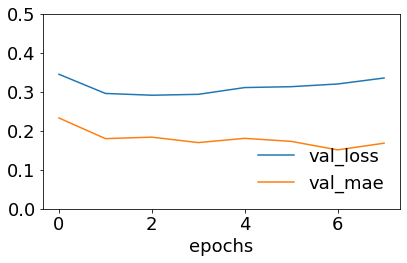

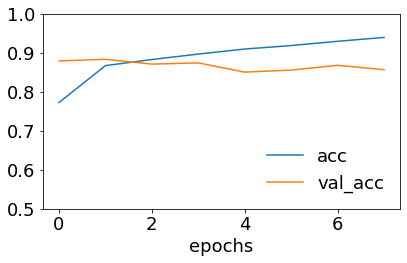

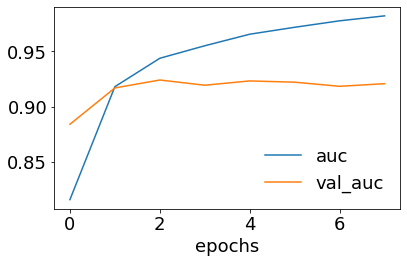

1083/1083 [==============================] - 1s 663us/sample - loss: 0.2591 - tp: 348.0000 - fp: 41.0000 - tn: 616.0000 - fn: 78.0000 - accuracy: 0.8901 - precision: 0.8946 - recall: 0.8169 - auc: 0.9481 - mae: 0.1711
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 34s 4ms/sample - loss: 0.4933 - tp: 1814.0000 - fp: 250.0000 - tn: 5044.0000 - fn: 1665.0000 - accuracy: 0.7817 - precision: 0.8789 - recall: 0.5214 - auc: 0.8180 - mae: 0.3425 - val_loss: 0.3463 - val_tp: 246.0000 - val_fp: 9.0000 - val_tn: 611.0000 - val_fn: 109.0000 - val_accuracy: 0.8790 - val_precision: 0.9647 - val_recall: 0.6930 - val_auc: 0.8887 - val_mae: 0.2400
Epoch 2/200
8773/8773 [==============================] - 28s 3ms/sample - loss: 0.3193 - tp: 2587.0000 - fp: 213.0000 - tn: 5081.0000 - fn: 892.0000 - accuracy: 0.8740 - precision: 0.9239 - recall: 0.7436 - auc: 0.9188 - mae: 0.2137 - val_loss: 0.3022 - val_tp: 266.0000 - val_fp: 44.00

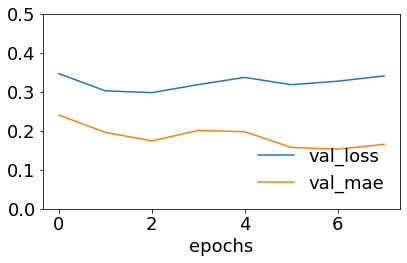

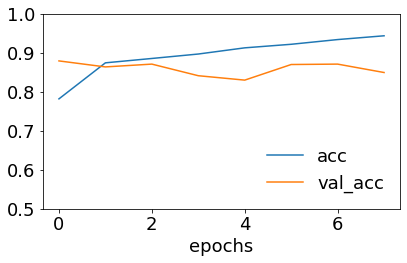

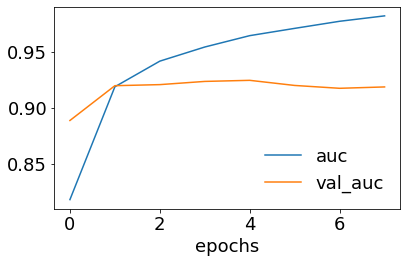

1083/1083 [==============================] - 1s 674us/sample - loss: 0.2802 - tp: 316.0000 - fp: 23.0000 - tn: 634.0000 - fn: 110.0000 - accuracy: 0.8772 - precision: 0.9322 - recall: 0.7418 - auc: 0.9406 - mae: 0.1669
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 33s 4ms/sample - loss: 0.5751 - tp: 759.0000 - fp: 3.0000 - tn: 5296.0000 - fn: 2715.0000 - accuracy: 0.6902 - precision: 0.9961 - recall: 0.2185 - auc: 0.8157 - mae: 0.3988 - val_loss: 0.4594 - val_tp: 193.0000 - val_fp: 1.0000 - val_tn: 614.0000 - val_fn: 167.0000 - val_accuracy: 0.8277 - val_precision: 0.9948 - val_recall: 0.5361 - val_auc: 0.9058 - val_mae: 0.3133
Epoch 2/200
8773/8773 [==============================] - 28s 3ms/sample - loss: 0.4177 - tp: 2400.0000 - fp: 184.0000 - tn: 5115.0000 - fn: 1074.0000 - accuracy: 0.8566 - precision: 0.9288 - recall: 0.6908 - auc: 0.9231 - mae: 0.2920 - val_loss: 0.3746 - val_tp: 284.0000 - val_fp: 52.000

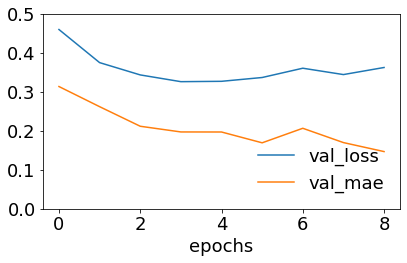

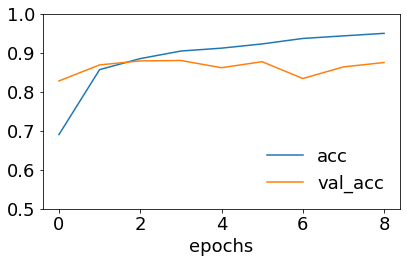

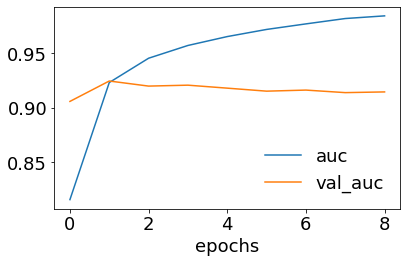

1083/1083 [==============================] - 1s 668us/sample - loss: 0.2926 - tp: 348.0000 - fp: 30.0000 - tn: 627.0000 - fn: 78.0000 - accuracy: 0.9003 - precision: 0.9206 - recall: 0.8169 - auc: 0.9418 - mae: 0.1860
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/200
8773/8773 [==============================] - 33s 4ms/sample - loss: 0.4575 - tp: 1937.0000 - fp: 195.0000 - tn: 5101.0000 - fn: 1540.0000 - accuracy: 0.8022 - precision: 0.9085 - recall: 0.5571 - auc: 0.8520 - mae: 0.3167 - val_loss: 0.3441 - val_tp: 281.0000 - val_fp: 63.0000 - val_tn: 555.0000 - val_fn: 76.0000 - val_accuracy: 0.8574 - val_precision: 0.8169 - val_recall: 0.7871 - val_auc: 0.9061 - val_mae: 0.2317
Epoch 2/200
8773/8773 [==============================] - 28s 3ms/sample - loss: 0.2826 - tp: 2741.0000 - fp: 245.0000 - tn: 5051.0000 - fn: 736.0000 - accuracy: 0.8882 - precision: 0.9180 - recall: 0.7883 - auc: 0.9418 - mae: 0.1880 - val_loss: 0.3095 - val_tp: 281.0000 - val_fp: 40.00

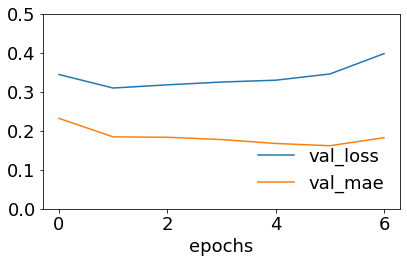

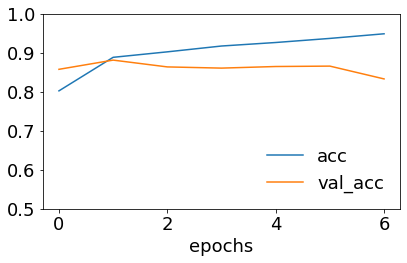

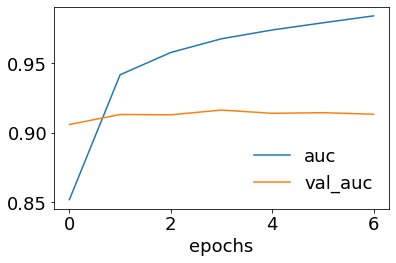

8773/8773 [==============================] - 33s 4ms/sample - loss: 0.4689 - tp: 1948.0000 - fp: 240.0000 - tn: 5063.0000 - fn: 1522.0000 - accuracy: 0.7992 - precision: 0.8903 - recall: 0.5614 - auc: 0.8540 - mae: 0.3352 - val_loss: 0.3405 - val_tp: 252.0000 - val_fp: 18.0000 - val_tn: 593.0000 - val_fn: 112.0000 - val_accuracy: 0.8667 - val_precision: 0.9333 - val_recall: 0.6923 - val_auc: 0.8982 - val_mae: 0.2161
Epoch 2/200
8773/8773 [==============================] - 28s 3ms/sample - loss: 0.2918 - tp: 2693.0000 - fp: 271.0000 - tn: 5032.0000 - fn: 777.0000 - accuracy: 0.8805 - precision: 0.9086 - recall: 0.7761 - auc: 0.9356 - mae: 0.1931 - val_loss: 0.3135 - val_tp: 275.0000 - val_fp: 46.0000 - val_tn: 565.0000 - val_fn: 89.0000 - val_accuracy: 0.8615 - val_precision: 0.8567 - val_recall: 0.7555 - val_auc: 0.9148 - val_mae: 0.1838
Epoch 3/200
8773/8773 [==============================] - 28s 3ms/sample - loss: 0.2466 - tp: 2851.0000 - fp: 274.0000 - tn: 5029.0000 - fn: 619.0000 -

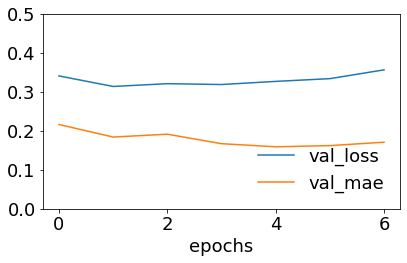

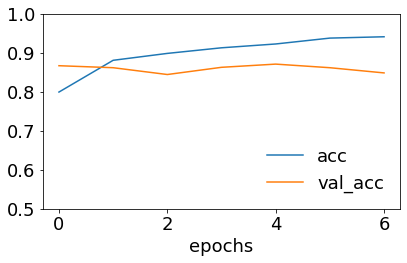

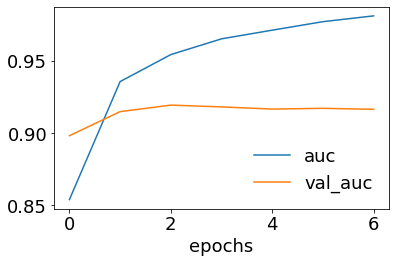

1083/1083 [==============================] - 1s 669us/sample - loss: 0.2750 - tp: 330.0000 - fp: 31.0000 - tn: 626.0000 - fn: 96.0000 - accuracy: 0.8827 - precision: 0.9141 - recall: 0.7746 - auc: 0.9408 - mae: 0.1691


In [0]:
# some configuration
VALIDATION_SPLIT = 0.1   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 200   # number of complete passes through the training dataset
LEARNING_RATE = 5E-5
N_SPLITS = 10

print('Building Bi-LSTM model...')
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state = 7)
cvscores_bilstm_cnn_tf = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'f1', 'auc', 'cohen-kappa-score'])
labels = data_cleaned['relevance'].values
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      'mae'
]

embedding_layer = tf.keras.layers.Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=True
)


for train, test in kfold.split(texts_tf, labels):

  x_train = texts_tf[train]
  x_test = texts_tf[test]
  x_train_1 = x_train[:, : MAX_SEQUENCE_LENGTH] # training set for word embeddings using GloVe
  x_train_2 = x_train[:, MAX_SEQUENCE_LENGTH:] # training set for tfidf feature
  x_test_1 = x_test[:, :MAX_SEQUENCE_LENGTH] # testing set for word embedding using GloVe
  x_test_2 = x_test[:, MAX_SEQUENCE_LENGTH:] # testing set for tfidf feature
  y_train = labels[train]
  y_test = labels[test]

  input_1 = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,)) # input layer using word embeddings
  x = embedding_layer(input_1)
  x = tf.keras.layers.Conv1D(filters = EMBEDDING_DIM, kernel_size = 3, padding='valid', activation='relu')(x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)   # LSTM layer on embedding layer
 
  input_2 = tf.keras.Input(shape=(500,))  #input layer using tfidf
  tf_vec = tf.keras.layers.LayerNormalization()(input_2)  # tfidf layer
  tf_vec = tf.keras.layers.Dense(32, activation = 'relu')(tf_vec) # reduce the dimension of tfidf layer to 32
  
  concat_layer = tf.keras.layers.Concatenate()([x, tf_vec])  # concatenate LSTM and tfidf layer

  output_vector = tf.keras.layers.Dense(16, activation='relu')(concat_layer)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(output_vector)
  model = tf.keras.models.Model([input_1, input_2], output)
  
  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    metrics = METRICS,
  
  )



# Training model:

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)  # early stopping to avoid overfitting
#  mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
# fit model
# load a saved model

#  from sklearn.utils import class_weight

  print('Training model...')
  r1 = model.fit(
    [x_train_1, x_train_2],
    y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT,
    #callbacks=[history, lrate]
    #callbacks=[lr_schedule]
    callbacks=[es]
    #class_weight = class_weight_dict
    #use_multiprocessing=True
  )

#  saved_model = tf.keras.models.load_model('best_model.h5')
#  saved_model.summary()

  model.summary()

  figure(figsize=(6, 4))
  plt.rcParams.update({'figure.autolayout': True, 'font.size':18})
# plot some data
#  plt.plot(r1.history['loss'], label='loss')
  plt.plot(r1.history['val_loss'], label='val_loss')
  plt.plot(r1.history['val_mae'], label='val_mae')
  plt.xlabel('epochs')
  plt.ylim(0, 0.5)
  plt.legend(frameon=False, loc = 'lower right')  
  plt.show()

# accuracies
  figure(figsize=(6, 4))
  plt.rcParams.update({'figure.autolayout': True, 'font.size':18})
  plt.plot(r1.history['accuracy'], label='acc')
  plt.plot(r1.history['val_accuracy'], label='val_acc')
  plt.xlabel('epochs')
  plt.ylim(0.5, 1)
  plt.legend(frameon=False, loc = 'lower right')
  plt.show()

# auc
  figure(figsize=(6, 4))
  plt.rcParams.update({'figure.autolayout': True, 'font.size':18})
  plt.plot(r1.history['auc'], label='auc')
  plt.plot(r1.history['val_auc'], label='val_auc')
  plt.xlabel('epochs')
  plt.legend(frameon=False, loc = 'lower right')
  plt.show()



  #scores = saved_model.evaluate(x = texts[test], y = labels[test])
  scores = model.evaluate(x = [x_test_1, x_test_2], y = y_test)
  y_pred = model.predict(x=[x_test_1, x_test_2])
  y_pred = K.round(y_pred)
  ck = cohen_kappa_score(labels[test], y_pred)
  cvscores_bilstm_cnn_tf = cvscores_bilstm_cnn_tf.append({'tp': scores[1], 'fp': scores[2], 'tn': scores[3], 'fn': scores[4], 
                              'accuracy': scores[5],'precision': scores[6], 'recall': scores[7], 
                              'f1': 2 * (scores[6] * scores[7]) / (scores[6] + scores[7]),'auc': scores[8],
                              'cohen-kappa-score': ck}, ignore_index=True)

In [0]:
cvscores_bilstm_cnn_tf

,tp,fp,tn,fn,accuracy,precision,recall,f1,auc,cohen-kappa-score
0,307.0,28.0,630.0,119.0,0.864391,0.916418,0.720657,0.806833,0.914449,0.704640
1,304.0,26.0,631.0,122.0,0.863343,0.921212,0.713615,0.804233,0.924327,0.701846
2,317.0,25.0,632.0,109.0,0.876270,0.926901,0.744131,0.825521,0.941450,0.731435
3,315.0,26.0,631.0,111.0,0.873500,0.923754,0.739437,0.821382,0.921783,0.725305
4,327.0,37.0,620.0,99.0,0.874423,0.898352,0.767606,0.827848,0.942939,0.729966
5,348.0,41.0,616.0,78.0,0.890120,0.894602,0.816901,0.853988,0.948128,0.766196
6,316.0,23.0,634.0,110.0,0.877193,0.932153,0.741784,0.826144,0.940593,0.733097
7,348.0,30.0,627.0,78.0,0.900277,0.920635,0.816901,0.865672,0.941818,0.786825
8,322.0,36.0,621.0,104.0,0.870729,0.899441,0.755869,0.821429,0.930991,0.721315
9,330.0,31.0,626.0,96.0,0.882733,0.914127,0.774648,0.838628,0.940816,0.747515


In [0]:
cvscores_bilstm_cnn_tf.mean()

tp                   323.400000
fp                    30.300000
tn                   626.800000
fn                   102.600000
accuracy               0.877298
precision              0.914759
recall                 0.759155
f1                     0.829168
auc                    0.934729
cohen-kappa-score      0.734814
dtype: float64

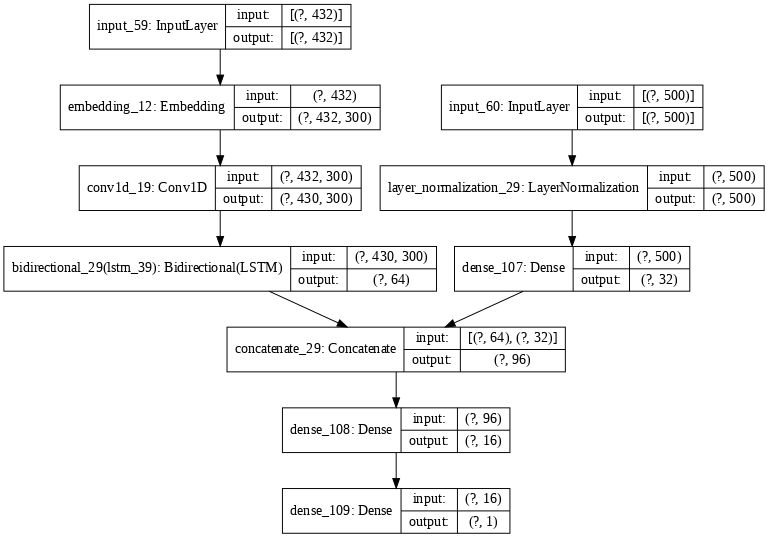

In [0]:
plot_model(model, to_file='model_plot_bilstm_att.png', show_shapes=True, show_layer_names=True, dpi = 200)